<a href="https://colab.research.google.com/github/abyaadrafid/APTOS-Blindness-Detection/blob/master/bangla_handwritten_grapheme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
torch.get_num_threads()

2

In [0]:
torch.set_num_threads(4)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/kaggle/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/kaggle/test.csv')
df_class = pd.read_csv('/content/gdrive/My Drive/kaggle/class_map.csv')
df_submission = pd.read_csv('/content/gdrive/My Drive/kaggle/sample_submission.csv')

In [0]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
#     parquet_locs = notebook.tqdm(parquet_locs)
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
ds = make_tensordataset_from_dfs(['/content/gdrive/My Drive/kaggle/train_image_data_{}.parquet'.format(i) for i in range(4)], '/content/gdrive/My Drive/kaggle/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

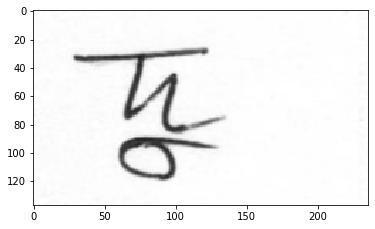

In [10]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [0]:
# tmp = torch.nonzero(ds[100000][0] < 100)

In [0]:
# tmp[:, 1].max(), tmp[:, 1].min(), tmp[:, 2].max(), tmp[:, 2].min()

In [0]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [0]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [15]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size), 
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(make_linear_block(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

def make_squeeze_predictor(in_size, out_size):
    return nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_size, out_size, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten()
        )

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
#         base = models.squeezenet1_0(pretrained=True).features
        base = models.resnet18(pretrained=False)
        base.fc = nn.Identity()
        self.base = base
        feature_size = 512
        self.grapheme_predictor = make_ff_predictor(feature_size, 512, n_graphemes, 2)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 1)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 1)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
#         with torch.no_grad():
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [0]:
class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks, init_weight=None):
        super(MultiTaskLoss, self).__init__()
        self.n = num_tasks
        if init_weight is None:
            self.w = nn.Parameter(torch.ones(self.n))
        else:
            self.w = nn.Parameter(torch.tensor(init_weight))

    def forward(self, losses):
        return torch.sum(self.w * losses) - torch.sum(torch.sum(torch.log(self.w)))

In [0]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [0]:
model.convert_to_grayscale()

In [33]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/model.pth', map_location=device))

<All keys matched successfully>

In [0]:
model.unfreeze()

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=256, num_workers=0, pin_memory=True, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=256, num_workers=0, pin_memory=True)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
tr_losses = []
va_losses = []

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [0]:
def run_epoch(num_epochs):
  epochs = tqdm_notebook(range(num_epochs))
  for epoch in epochs:
      model.train()
      count = 0
      batches = tr_dl
      batches = tqdm_notebook(tr_dl)
      for batch in batches:
          count += 1
          optimizer.zero_grad()
          img, g, v, c = batch
          img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
          img,g_a,g_b,lam=mixup_data(img,g,alpha=0.15)
          img = img / 255.0
          g_pred, v_pred, c_pred = model(img)
          g_loss = mixup_criterion(criterion,g_pred, g_a,g_b,lam)
          v_loss = criterion(v_pred, v)
          c_loss = criterion(c_pred, c)
          loss = 2.0 * g_loss + v_loss + c_loss
  #         loss = mtl_criterion(torch.stack((g_loss, v_loss, c_loss)))
  #         batches.set_description("{:0.4f} {:0.4f} {:0.4f} {:0.4f}".format(loss.item(), g_loss.item(), v_loss.item(), c_loss.item()))
          loss.backward()
          optimizer.step()
          tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
  #     print(mtl_criterion.w)
      print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
      with torch.no_grad():
          model.eval()
          avg_g_loss = 0.0
          avg_v_loss = 0.0
          avg_c_loss = 0.0
          g_true = []
          v_true = []
          c_true = []
          g_preds = []
          v_preds = []
          c_preds = []
          count = 0
          batches = va_dl
          batches = tqdm_notebook(va_dl)
          for batch in batches:
              count += 1
              img, g, v, c = batch
              img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
              img = img / 255.0
              g_pred, v_pred, c_pred = model(img)
              g_loss = criterion(g_pred, g)           
              v_loss = criterion(v_pred, v)
              c_loss = criterion(c_pred, c)
              avg_g_loss += g_loss.item()
              avg_v_loss += v_loss.item()
              avg_c_loss += c_loss.item()
              g_true.extend(g.tolist())
              v_true.extend(v.tolist())
              c_true.extend(c.tolist())
              g_preds.extend(g_pred.argmax(1).tolist())
              v_preds.extend(v_pred.argmax(1).tolist())
              c_preds.extend(c_pred.argmax(1).tolist())
          avg_g_loss /= count
          avg_v_loss /= count
          avg_c_loss /= count
          va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
          print(sum(va_losses[-1]), va_losses[-1])
          print(recall_score(g_true, g_preds, average='macro'))
          print(recall_score(v_true, v_preds, average='macro'))
          print(recall_score(c_true, c_preds, average='macro'))
          print(confusion_matrix(v_true, v_preds))
          print(confusion_matrix(c_true, c_preds))
          plt.figure(figsize = (20, 20))
          sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
          plt.show()

8.238509246112603 4.203259960090929 2.1444556847994534 1.8907936012222204


5.6313307043872305 (2.6951259751863117, 1.3372635554663743, 1.5989411737345443)
0.2788191611131035
0.510892965764332
0.40471218940811626
[[3774   54   26    9   83   53   81  160    2    4    2]
 [1475 1725   69   75   32   20   15  198    3   41    9]
 [  92    1 2348    1    5    2    4  122    1    0    1]
 [ 256   87   45 1116   19    6    1   29    4    7    9]
 [ 496    4    7    0 1064  129   73  107    1    0    0]
 [ 213   10    0    0   74  151   49   25    0    0    0]
 [ 177    1    1    0   41   27  196    5    0    0    0]
 [ 206    2   47    3    2    7    6 2576    2    8    0]
 [  43    0   58    1    4    0    4  215    6    0    2]
 [  13   42   45    6    1    1    0 1121    3  371   15]
 [   1    6   27   18    0    0    0  170    3   60   72]]
[[4654  217 3081  150 2098  585 1770]
 [  15   68  533    1   22   15   39]
 [  29   18 2173    1   25   18   44]
 [   0    0   44    0   18    0    0]
 [  67    4  124   13 1868   36   35]
 [ 247   39  381   14  157 1201  1

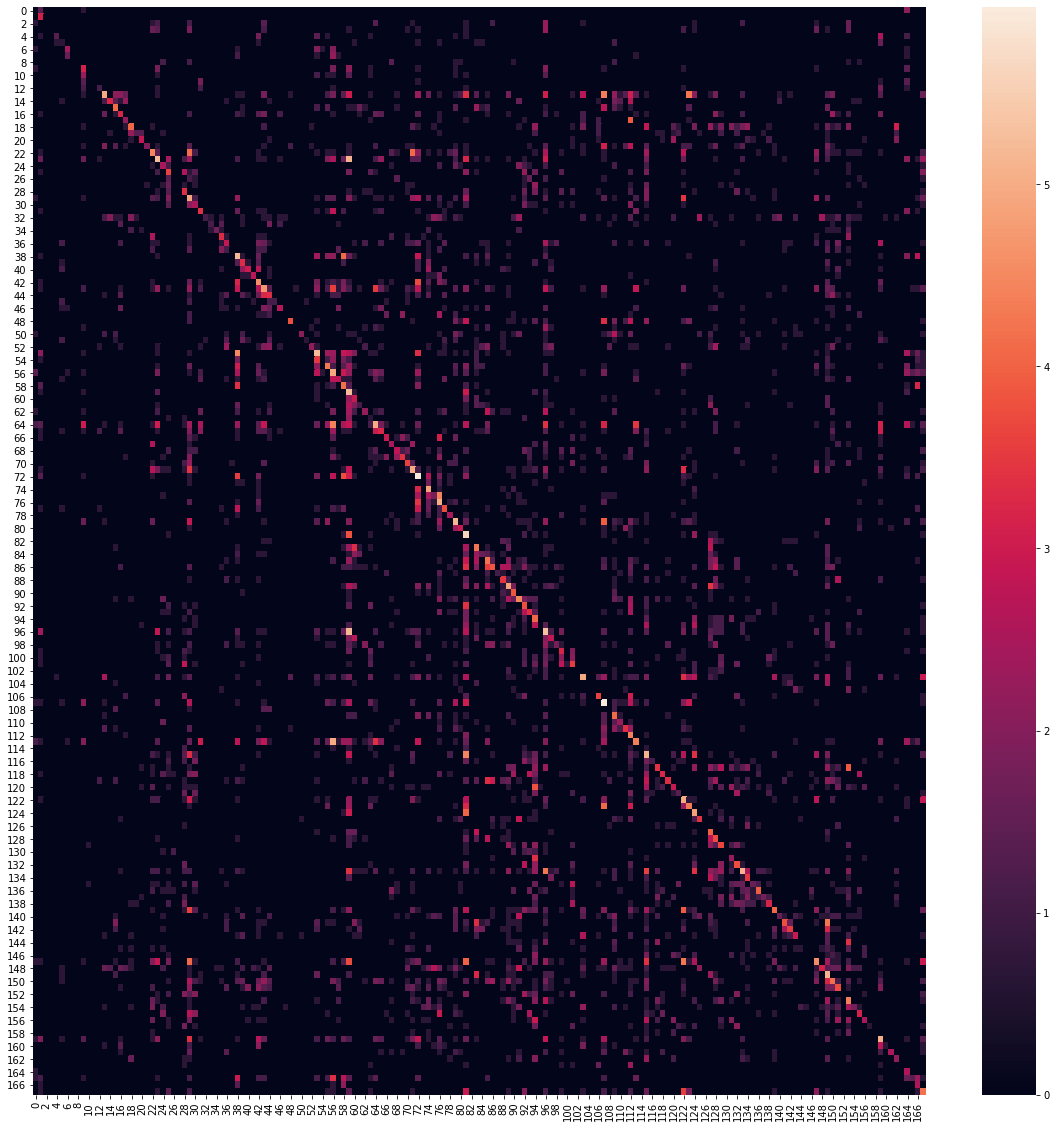

6.94001347884599 3.1429753174538995 2.0252650307631055 1.771773130628985


4.00214515003977 (1.6190523829641221, 1.4336536021172246, 0.9494391649584227)
0.6059190192089831
0.7116087720733364
0.662010049122
[[1887   78  170   91  425   50  352 1051   99   24   21]
 [  42 1384  118  388  115    6  434  171  182  717  105]
 [   1    0 2375    0    0    1   24   94   42    1   39]
 [   1    8   26 1384    2    1   43    5   19    1   89]
 [  46    1   23    3 1567    5   69  149   12    0    6]
 [  18   13    7    0  189  169   66   43    3   12    2]
 [   6    0    0    0   26    5  389   18    1    0    3]
 [   1    0    9    1    2    1    3 2767   18   41   16]
 [   0    1   22    0    1    0    0   79  214    3   13]
 [   0    2    4    1    0    0   14  295   13 1102  187]
 [   0    0    3    0    0    1    1   19    1   14  318]]
[[11868   169   322     1    54   140     1]
 [   76   539    73     0     1     4     0]
 [  297    65  1913     2     0    31     0]
 [    1     5    17    28    10     0     1]
 [  560    41    35     4  1489     9     9]
 [  7

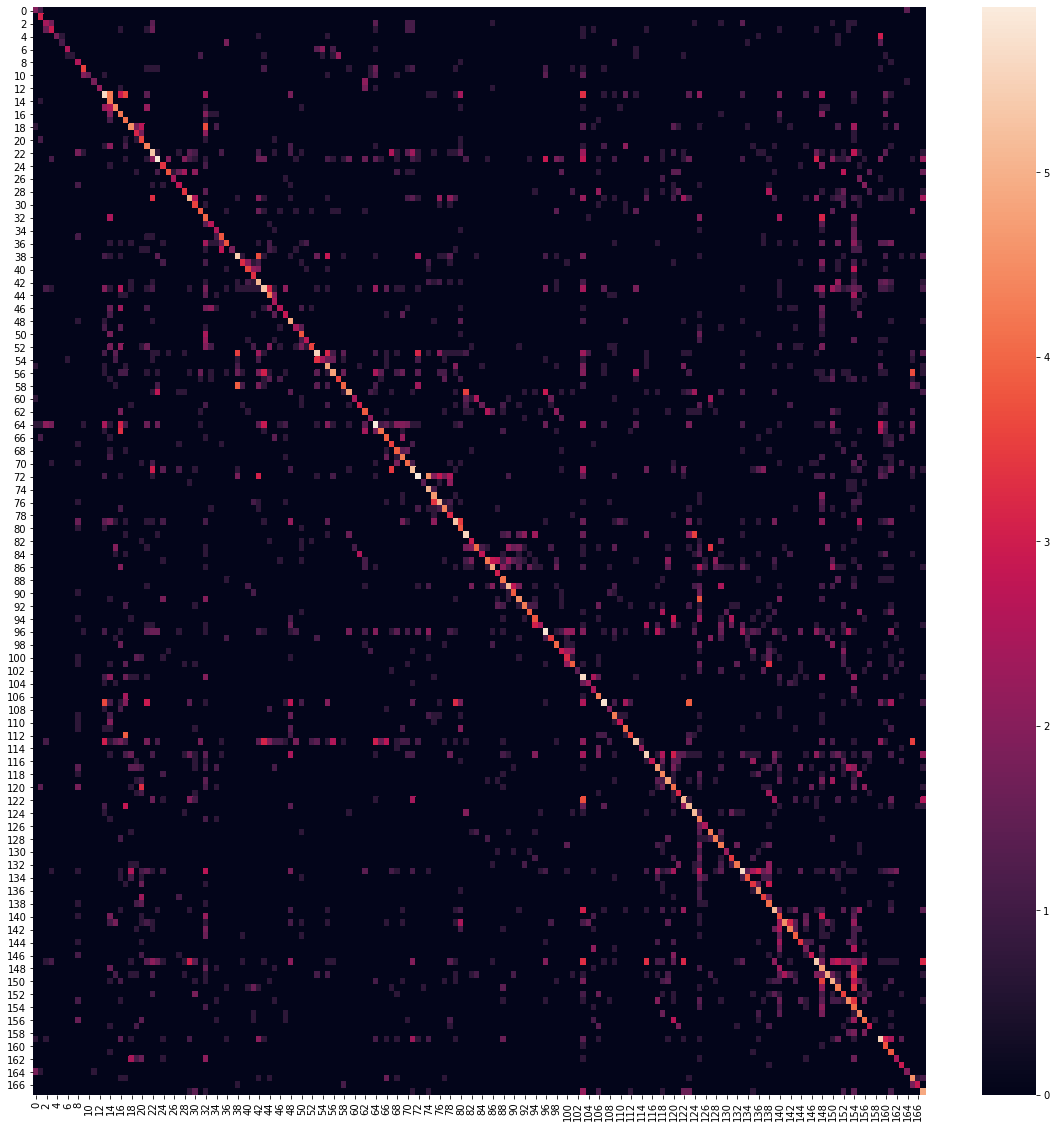

6.249453140395478 2.5971074658483335 1.9618404069243598 1.6905052676227845


2.935443450378466 (1.062327655055855, 1.0343433724174016, 0.8387724229052097)
0.7386238045026308
0.8147600941714483
0.7255538367780963
[[2402  852  360   48   89   18   46  407    7   15    4]
 [  13 3443   24   42    3    2    1    8    0  122    4]
 [   1    0 2566    1    0    0    0    5    1    3    0]
 [   1   39   12 1505    0    0    0    0    0    5   17]
 [ 109   46   38    6 1605    5   10   60    0    1    1]
 [  41   59   13    0   93  272    7   30    0    7    0]
 [  14   22    4    0   26   25  334   23    0    0    0]
 [   0    1   81    2    0    0    0 2530   13  224    8]
 [   0    0   47    0    0    0    0   42  229   12    3]
 [   0    9    3    0    0    0    0   24    2 1564   16]
 [   0    0    0    0    0    0    0    1    0   53  303]]
[[12171    12   100     0    52   219     1]
 [   98   544    44     0     0     7     0]
 [  480    12  1755     0     2    59     0]
 [    0     0     1    21    40     0     0]
 [  254     1    14     0  1856    12    10]
 

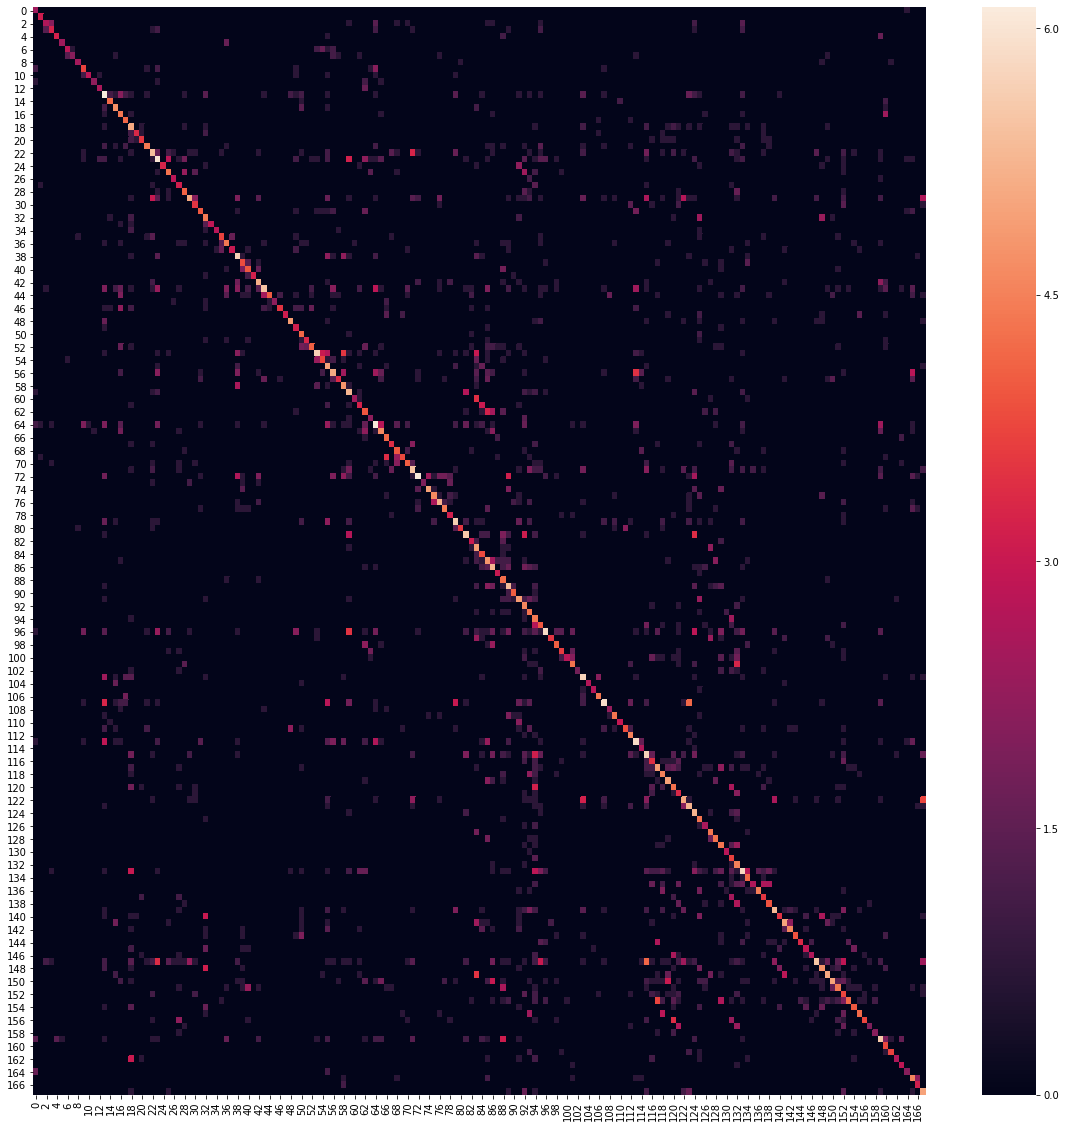

5.807211583540834 2.2571329926753143 1.9173358289743583 1.6327427618911614


2.9142415614067754 (0.7895442843437195, 0.8336936967282356, 1.2910035803348203)
0.7969742351624044
0.8666267819008879
0.8761120289729794
[[3775  182   24    8  151   12   21   51   19    5    0]
 [  57 3481    4   31   11    2    2   16    9   48    1]
 [   7    2 2554    1    2    0    0    8    2    1    0]
 [   9   27    1 1531    4    0    0    2    0    2    3]
 [  76    7    2    0 1790    1    2    3    0    0    0]
 [  29   29    3    0  149  298   13    0    0    1    0]
 [  38    2    1    0   62   10  334    1    0    0    0]
 [  17    0   21    1    8    0    0 2745    5   62    0]
 [   2    0   18    0    1    0    0   48  257    6    1]
 [   0   13    5    0    0    1    0   57    6 1526   10]
 [   0    1    1    1    0    0    0   25    0   47  282]]
[[7785   69 3030    1  616 1037   17]
 [   7  622   58    0    2    4    0]
 [  39    5 2231    3    2   26    2]
 [   0    0    5   54    3    0    0]
 [  21    0   63   14 1988    8   53]
 [  25    1   60    0   12 2024   

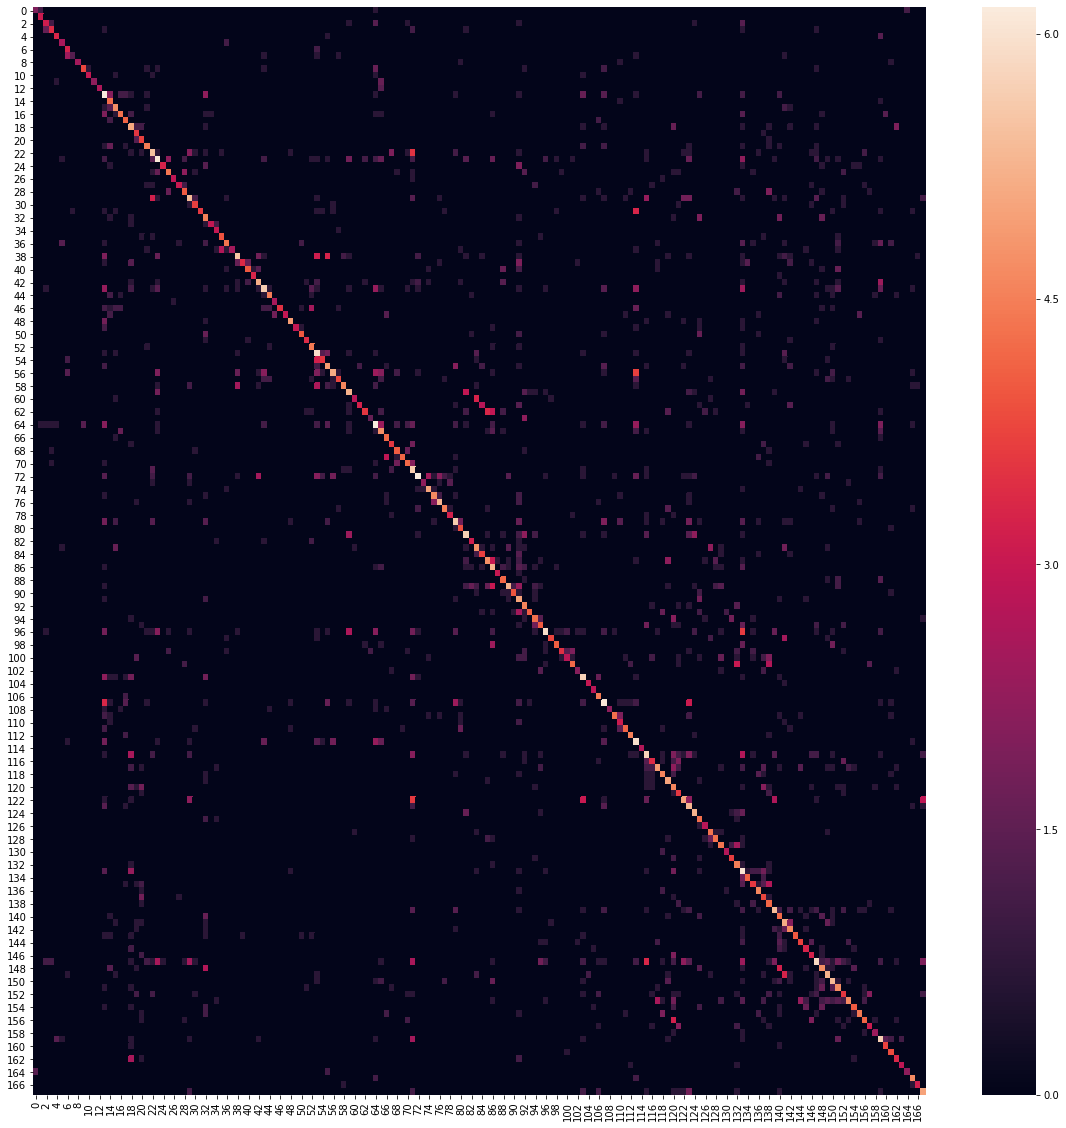

5.499893613170195 2.027055257103568 1.8849975892475672 1.5878407668190595


2.802881628652162 (0.6195582430573958, 0.8889993074574049, 1.2943240781373615)
0.8337836852105486
0.9154795829399255
0.8887586957609864
[[3629  173   16   39  240   37   29   70    4    6    5]
 [  51 3413    3   97   23    8    2   11    3   47    4]
 [   8    0 2547    1    2    0    1   12    4    0    2]
 [   5    9    0 1557    1    0    0    0    0    1    6]
 [  28    5    2    1 1829    6    7    3    0    0    0]
 [  13   11    0    1   75  410   10    1    0    1    0]
 [  18    5    0    0   22   24  379    0    0    0    0]
 [  10    0   10    1    5    0    0 2762   14   52    5]
 [   1    0    6    0    1    0    0   22  296    3    4]
 [   0   11    0    1    3    1    0   49    4 1499   50]
 [   0    0    0    3    1    0    0    9    0   14  330]]
[[7397  185 3588    0  534  848    3]
 [   4  661   18    0    2    3    5]
 [  33   32 2168   39    5   29    2]
 [   0    0    0   60    2    0    0]
 [  23    2   40   38 2011    7   26]
 [  32    2   54    0    8 2108    

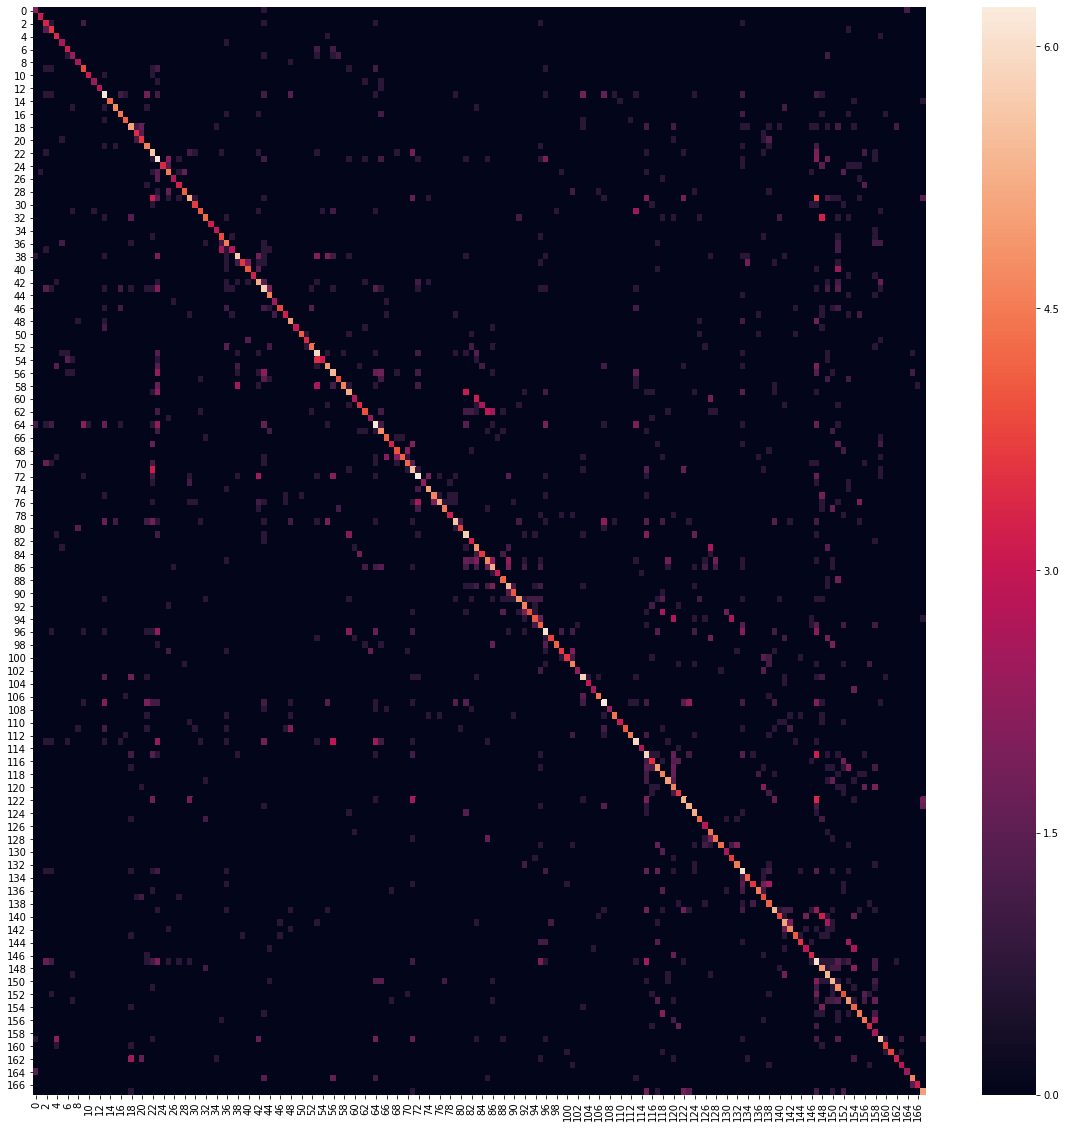

In [66]:
run_epoch(5)

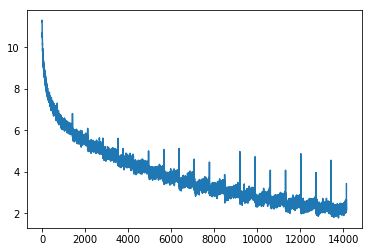

In [0]:
plt.plot([sum(t) for t in tr_losses])

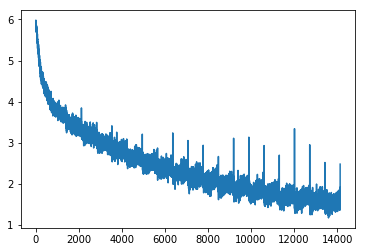

In [0]:
plt.plot([t[0] for t in tr_losses])

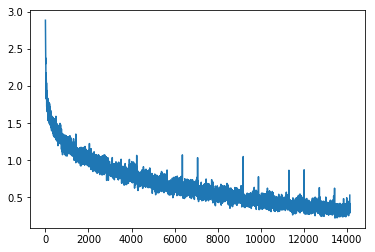

In [0]:
plt.plot([t[1] for t in tr_losses])

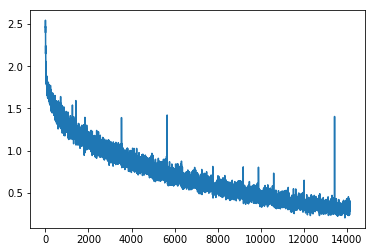

In [0]:
plt.plot([t[2] for t in tr_losses])

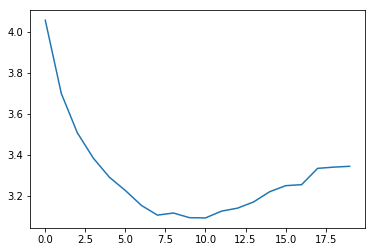

In [0]:
plt.plot([t[0] for t in va_losses])

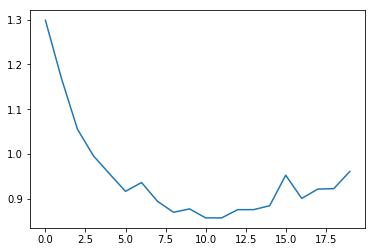

In [0]:
plt.plot([t[1] for t in va_losses])

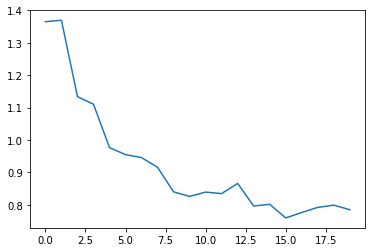

In [0]:
plt.plot([t[2] for t in va_losses])

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/bhgd_r50_mixup_p.pth')